In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.cluster import KMeans, MiniBatchKMeans

# Table of contents

1. [Load the data](#dataload)
2. [Visualisations](#vis)
3. [Distributions of coordinates](#distrcoord)
4. [Upseide/downside peptide analysis](#anomaly)
4. [Correlations among coordinates](#corr)
5. [Distribution of distances among peptides and CDRs](#distrdist)
6. [Clustering](#clust)
  - [Centroids](#centroids)
  - [Motifs](#motifs)

# Load the data and group it by unique keys for visualization

<a id="dataload"></a>

In [2]:
MAX_POS=12

df_put = pd.read_table("loops_13.putative_cdr.txt.gz", sep="\t")
df_cdr = pd.read_table("loops_13.real_cdr.txt.gz", sep="\t")

for key in set(df_put["pdb_id_kmer"]).intersection(df_cdr["pdb_id"]):
    df_put = df_put.loc[df_put["pdb_id_kmer"] != key,:]

In [3]:
print(df_put.columns)
df_put.columns = ["pdb_id", "chain", "start", "length", "pos", "aa", "x", "y", "z", "rmsd"]
print(df_put.isnull().values.any())
df_put["chain"] = df_put["chain"] + "_" + df_put["start"].astype('str')
print(df_put.isnull().values.any())
df_put.drop(["start"], inplace=True, axis=1)
df_put.head()

Index([u'pdb_id_kmer', u'chain_id_kmer', u'start_kmer', u'len_tcr', u'pos_tcr',
       u'aa_kmer', u'x_kmer', u'y_kmer', u'z_kmer', u'rmsd'],
      dtype='object')
False
False


pdb_id chain  length  pos aa         x         y          z      rmsd
0   12ca  A_72      13    0  A  0.000000  0.000000   0.000000  1.471901
1   12ca  A_72      13    1  V  2.435867  0.419666   2.914133  1.471901
2   12ca  A_72      13    2  L  3.901272 -1.472012   5.806936  1.471901
3   12ca  A_72      13    3  K  5.112862  0.373801   8.957265  1.471901
4   12ca  A_72      13    4  G  5.346375 -0.093429  12.738140  1.471901

In [4]:
print(df_cdr.columns)
df_cdr.columns = ["pdb_id", "chain", "length", "pos", "aa", "x", "y", "z"]
df_cdr.head()

Index([u'pdb_id', u'tcr_chain', u'len_tcr', u'pos_tcr', u'aa_tcr', u'x', u'y',
       u'z'],
      dtype='object')


pdb_id chain  length  pos aa         x         y         z
0   2iam   TRA      13    0  C  0.000000  0.000000  0.000000
1   2iam   TRA      13    1  A  2.509573  1.112225  2.513987
2   2iam   TRA      13    2  A  3.364967 -0.345859  5.977036
3   2iam   TRA      13    3  L  5.778524  0.067249  8.943966
4   2iam   TRA      13    4  I  8.380416 -2.555646  9.870885

In [5]:
print(df_put.isnull().values.any())
print(df_cdr.isnull().values.any())

False
False


In [6]:
tmp1 = df_put.loc[(df_put["pos"] == 0) & (df_put["aa"] == "C"), ["pdb_id", "chain"]]
tmp2 = df_put.loc[((df_put["pos"] == MAX_POS) & (df_put["aa"] == "F")) | 
                  (((df_put["pos"] == MAX_POS) & (df_put["aa"] == "W"))), 
                  ["pdb_id", "chain"]]
tmp3 = set(tmp1["pdb_id"] + "_" + tmp1["chain"]).intersection(set(tmp2["pdb_id"] + "_" + tmp2["chain"]))
tmp4 = list(df_put["pdb_id"] + "_" + df_put["chain"])

df_can = df_put.copy()
indices = []
for key in sorted(tmp3):
    indices.extend(range(tmp4.index(key), tmp4.index(key)+13))

df_can = df_can.iloc[indices, :]
# print(df_put.shape)
# df_put = df_put.iloc[indices, :]
# print(df_put.shape)
# print(df_can.shape)
df_can.head()

pdb_id chain  length  pos aa         x         y          z      rmsd
819   1a3r  H_94      13    0  C  0.000000  0.000000   0.000000  1.289135
820   1a3r  H_94      13    1  D  2.328698  1.425267   2.660179  1.289135
821   1a3r  H_94      13    2  G  3.429601 -0.679190   5.622885  1.289135
822   1a3r  H_94      13    3  Y  5.486569  0.740824   8.490734  1.289135
823   1a3r  H_94      13    4  Y  7.316678 -1.735490  10.741675  1.289135

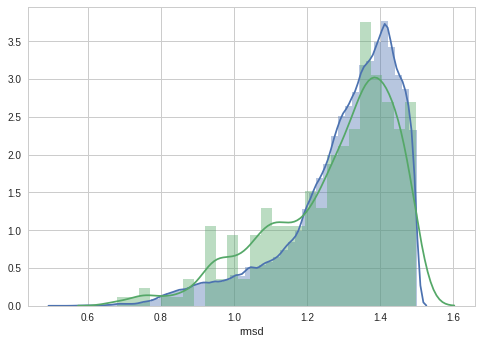

In [7]:
sns.distplot(df_put["rmsd"])
sns.distplot(df_can["rmsd"])

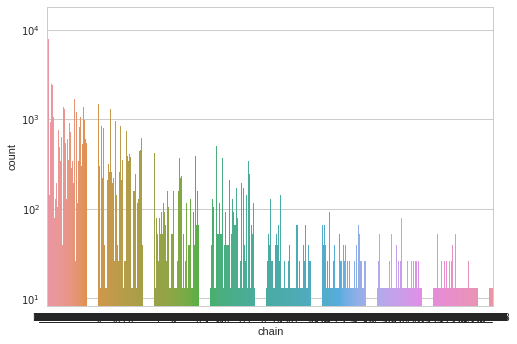

In [8]:
sns.countplot(df_put["chain"], log="y")

In [9]:
df_cdr.head()

pdb_id chain  length  pos aa         x         y         z
0   2iam   TRA      13    0  C  0.000000  0.000000  0.000000
1   2iam   TRA      13    1  A  2.509573  1.112225  2.513987
2   2iam   TRA      13    2  A  3.364967 -0.345859  5.977036
3   2iam   TRA      13    3  L  5.778524  0.067249  8.943966
4   2iam   TRA      13    4  I  8.380416 -2.555646  9.870885

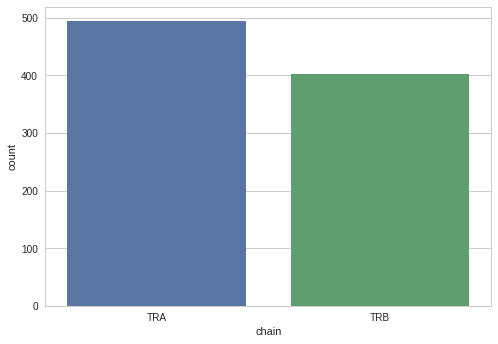

In [10]:
sns.countplot(df_cdr["chain"])

In [11]:
def save_df(df_inp, coord, filename):
    df = df_inp.pivot_table(coord, ["pdb_id", "chain"], columns="pos")
    df = df.reset_index()

    df2 = df_inp.pivot_table("aa", ["pdb_id", "chain"], aggfunc=sum)
    df2 = df2.reset_index()

    df["sequence"] = df2["aa"]
    df["key"] = df["pdb_id"] + "_" + df["chain"]
    df.drop(["pdb_id", "chain"], axis=1, inplace=True)
    df = df[["key", "sequence", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
    df.to_csv(filename, compression="gzip")
    print(df.shape)
    return df
    

df_put_coord_x = save_df(df_put, "x", "data/put_coord_x.csv.gz")
df_put_coord_y = save_df(df_put, "y", "data/put_coord_y.csv.gz")
df_put_coord_z = save_df(df_put, "z", "data/put_coord_z.csv.gz")

df_can_coord_x = save_df(df_can, "x", "data/can_coord_x.csv.gz")
df_can_coord_y = save_df(df_can, "y", "data/can_coord_y.csv.gz")
df_can_coord_z = save_df(df_can, "z", "data/can_coord_z.csv.gz")

df_cdr_coord_x = save_df(df_cdr, "x", "data/cdr_coord_x.csv.gz")
df_cdr_coord_y = save_df(df_cdr, "y", "data/cdr_coord_y.csv.gz")
df_cdr_coord_z = save_df(df_cdr, "z", "data/cdr_coord_z.csv.gz")

(74528, 15)
(74528, 15)
(74528, 15)
(281, 15)
(281, 15)
(281, 15)
(69, 15)
(69, 15)
(69, 15)


In [12]:
df_put_x = pd.melt(df_put, ["pdb_id", "chain", "pos"], "x")
df_put_y = pd.melt(df_put, ["pdb_id", "chain", "pos"], "y")
df_put_z = pd.melt(df_put, ["pdb_id", "chain", "pos"], "z")

df_can_x = pd.melt(df_can, ["pdb_id", "chain", "pos"], "x")
df_can_y = pd.melt(df_can, ["pdb_id", "chain", "pos"], "y")
df_can_z = pd.melt(df_can, ["pdb_id", "chain", "pos"], "z")

df_cdr_x = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "x")
df_cdr_y = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "y")
df_cdr_z = pd.melt(df_cdr, ["pdb_id", "chain", "pos"], "z")

# Visualization

<a id="vis"></a>

In [194]:
fig, ax = plt.subplots(2,3,figsize=(16,10))
ax[0,0].set_title("X, kmers")
ax[0,1].set_title("Y, kmers")
ax[0,2].set_title("Z, kmers")
ax[1,0].set_title("X, cdr")
ax[1,1].set_title("Y, cdr")
ax[1,2].set_title("Z, cdr")

df_tmp = df_put_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
print(len(df_tmp.groups.keys()))
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1,2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.1)

74528
281
69


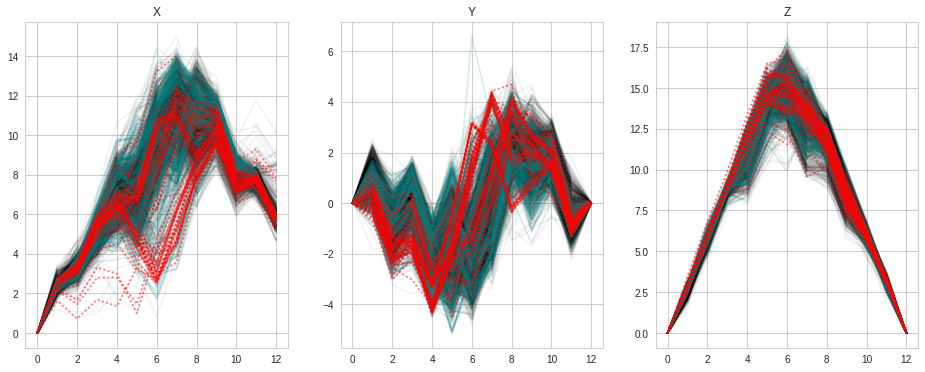

In [195]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")


df_tmp = df_put_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break

        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c="red", alpha=.5)

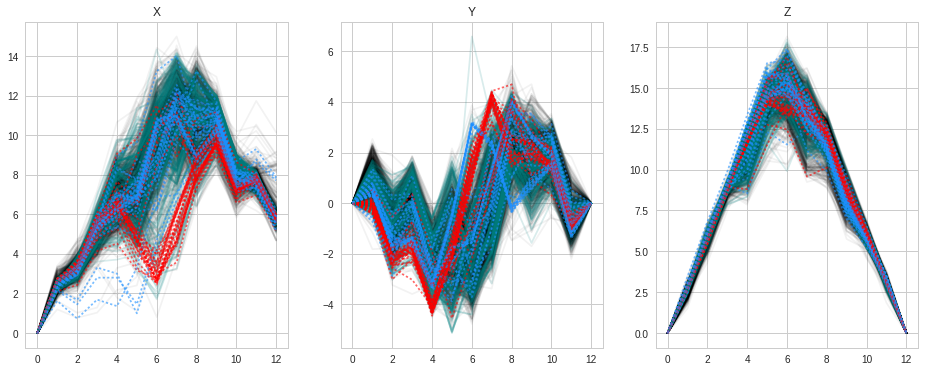

In [196]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")

df_tmp = df_put_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
df_tmp = df_put_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="black", alpha=.05)
    if i > 1000:
        break
        
        
df_tmp = df_can_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
df_tmp = df_can_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], c="teal", alpha=.15)
    if i > 1000:
        break
        
        
df_tmp = df_cdr_x.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[0].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_y.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[1].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)
        
df_tmp = df_cdr_z.groupby(["pdb_id", "chain"])
for i, gr in enumerate(df_tmp.groups.keys()):
    col = "dodgerblue" if gr[1] == "TRA" else "red"
    ax[2].plot(range(MAX_POS+1), df_tmp.get_group(gr)["value"], linestyle="dotted", c=col, alpha=.6)

## Summary
There is a clear distinction between TRA and TRB groups by the X-coordinate, with some anomalous CDRs.

TRB lines by the X-coordinate have very little neighbouring peptides in contrast to the TRA CDR chain sequences.

Real CDRs tend to have less deviation from the starting point and at the final point by the Y-coordinate.

Shape of lines for the Y-coordinate are pretty close for TRA and TRB.

# Distribution of coordinates per position

<a id="distrcoord"></a>

## X coordinate

In [197]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_x.loc[df_put_x["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_x.loc[df_can_x["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos"] == j) & (df_cdr_x["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_x.loc[(df_cdr_x["pos"] == j) & (df_cdr_x["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Y coordinate

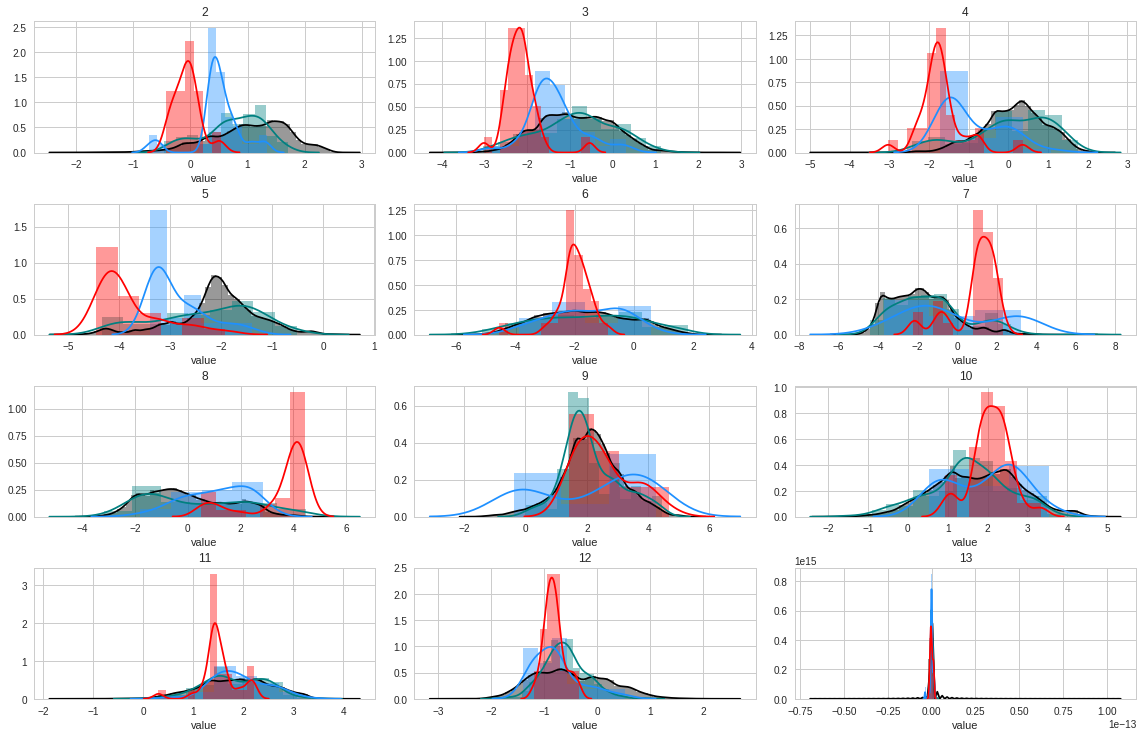

In [198]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_y.loc[df_put_y["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_y.loc[df_can_y["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos"] == j) & (df_cdr_y["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_y.loc[(df_cdr_y["pos"] == j) & (df_cdr_y["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Z coordinate

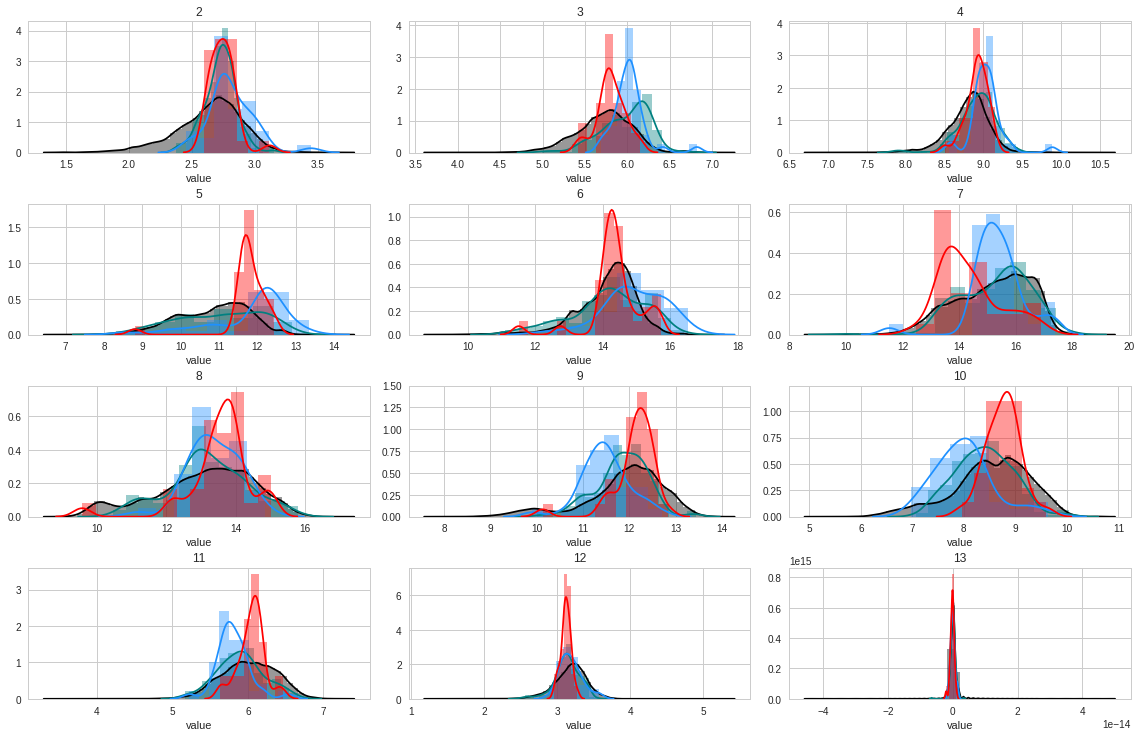

In [199]:
fig, ax = plt.subplots(4,3,figsize=(16,10))

plt.tight_layout(h_pad=3)

for j in range(1,MAX_POS+1):
    r,c = (j-1) // 3, (j-1) % 3
    sns.distplot(df_put_z.loc[df_put_z["pos"] == j, "value"], ax=ax[r,c], color="black")
    sns.distplot(df_can_z.loc[df_can_z["pos"] == j, "value"], ax=ax[r,c], color="teal")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos"] == j) & (df_cdr_z["chain"] == "TRA"), "value"], ax=ax[r,c], color="dodgerblue")
    sns.distplot(df_cdr_z.loc[(df_cdr_z["pos"] == j) & (df_cdr_z["chain"] == "TRB"), "value"], ax=ax[r,c], color="red")
    ax[r,c].set_title(j+1)

## Summary

Distributions of coordinates for almost all positions for X and Z coodinates are close to Gauss.

Distributions of X coordinates for putative, TRA and TRB CDRs are quite close for the first 6 positions, and 12/13 positions.

TRA and putative distributions at the X coordinate are very close for all positions.

TRB is much lower than TRA/putative for the X coordinate at positions 6,7,8,9,10,11.

Distributions of Y coordinates for real CDRs are lower than for the putative ones in the first 5 positions. For 7 and 8 positions real CDRs are higher than the putative ones. This effect is more stronger for TRB than for TRA. (Probably due to Gly).

Distributions of Z coordinates are very similar to each other for all peptides.

# "Upside" / "downside" peptides analysis

<a id="anomaly"></a>

In [200]:
df1 = df_cdr_x.loc[(df_cdr_x["pos"] == 2) & (df_cdr_x["value"] < 2) & (df_cdr_x["chain"] == "TRA"), :]
df2 = df_cdr_y.loc[(df_cdr_y["pos"] == 2) & (df_cdr_y["value"] < 0) & (df_cdr_y["chain"] == "TRA"), :]

df3 = df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] > 5) & (df_cdr_x["chain"] == "TRB"), :]
df4 = df_cdr_x.loc[(df_cdr_y["pos"] == 7) & (df_cdr_y["value"] < 3) & (df_cdr_y["chain"] == "TRB"), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(set(df1.pdb_id).intersection(set(df2.pdb_id)))
# print(df_cdr.loc[np.array(list(map(lambda x: x in set(df3.pdb_id).intersection(set(df4.pdb_id)), 
#                                    df_cdr_x["pdb_id"]))), :])

(3, 5)
(36, 5)
(7, 5)
(6, 5)
set(['3pqy', '4ozh', '4z7v'])


In [201]:
df1 = df_put_x.loc[(df_put_x["pos"] == 2) & (df_put_x["value"] < 2), :]
df2 = df_put_y.loc[(df_put_y["pos"] == 2) & (df_put_y["value"] < 0), :]

df3 = df_put_x.loc[(df_put_x["pos"] == 6) & (df_put_x["value"] > 5), :]
df4 = df_put_x.loc[(df_put_y["pos"] == 7) & (df_put_y["value"] < 3), :]

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)

(276, 5)
(62376, 5)
(71766, 5)
(72423, 5)


In [202]:
df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] < 6) & (df_cdr_x["chain"] == "TRA"), :]

pdb_id chain  pos variable     value
864   3pqy   TRA    6        x  4.706501
890   4z7v   TRA    6        x  4.205619

In [203]:
df_cdr_x.loc[(df_cdr_x["pos"] == 4) & (df_cdr_x["value"] < 4) & (df_cdr_x["chain"] == "TRA"), :]

pdb_id chain  pos variable     value
524   4ozh   TRA    4        x  1.357835
862   3pqy   TRA    4        x  2.798550
888   4z7v   TRA    4        x  3.000207

In [204]:
df_cdr_x.loc[(df_cdr_x["pos"] == 6) & (df_cdr_x["value"] > 6) & (df_cdr_x["chain"] == "TRB"), :]

pdb_id chain  pos variable      value
32    2xn9   TRB    6        x  11.144908
71    3vxr   TRB    6        x   9.548838
97    3vxs   TRB    6        x   9.711765
136   4y1a   TRB    6        x  10.337111
279   4y19   TRB    6        x   8.448482
331   3o4l   TRB    6        x  11.509035
877   1d9k   TRB    6        x  10.139364

# Correlations among coordinates

<a id="corr"></a>

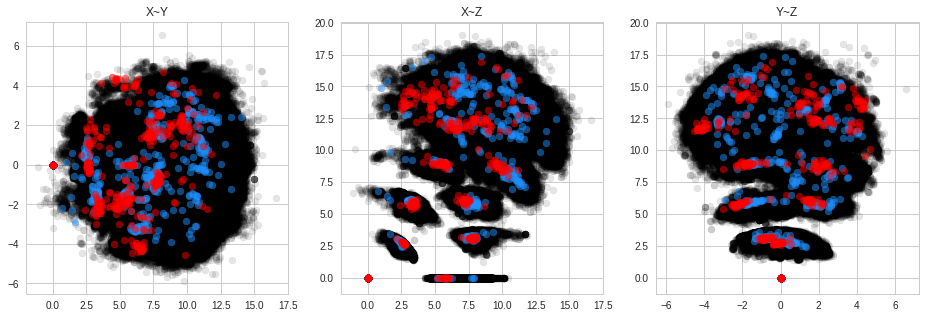

In [205]:
fig, ax = plt.subplots(1,3,figsize=(16,5))

ax[0].scatter(df_put_x["value"], df_put_y["value"], color="black", alpha=.1)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRA"), "value"], df_cdr_y.loc[(df_cdr_y["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[0].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRB"), "value"], df_cdr_y.loc[(df_cdr_y["chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[0].set_title("X~Y")

ax[1].scatter(df_put_x["value"], df_put_z["value"], color="black", alpha=.1)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[1].scatter(df_cdr_x.loc[(df_cdr_x["chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRB"), "value"], color="red", alpha=.5)
ax[1].set_title("X~Z")

ax[2].scatter(df_put_y["value"], df_put_z["value"], color="black", alpha=.1)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["chain"] == "TRA"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRA"), "value"], color="dodgerblue", alpha=.5)
ax[2].scatter(df_cdr_y.loc[(df_cdr_y["chain"] == "TRB"), "value"], df_cdr_z.loc[(df_cdr_z["chain"] == "TRB"), "value"], color="red", alpha=.5)

ax[2].set_title("Y~Z")

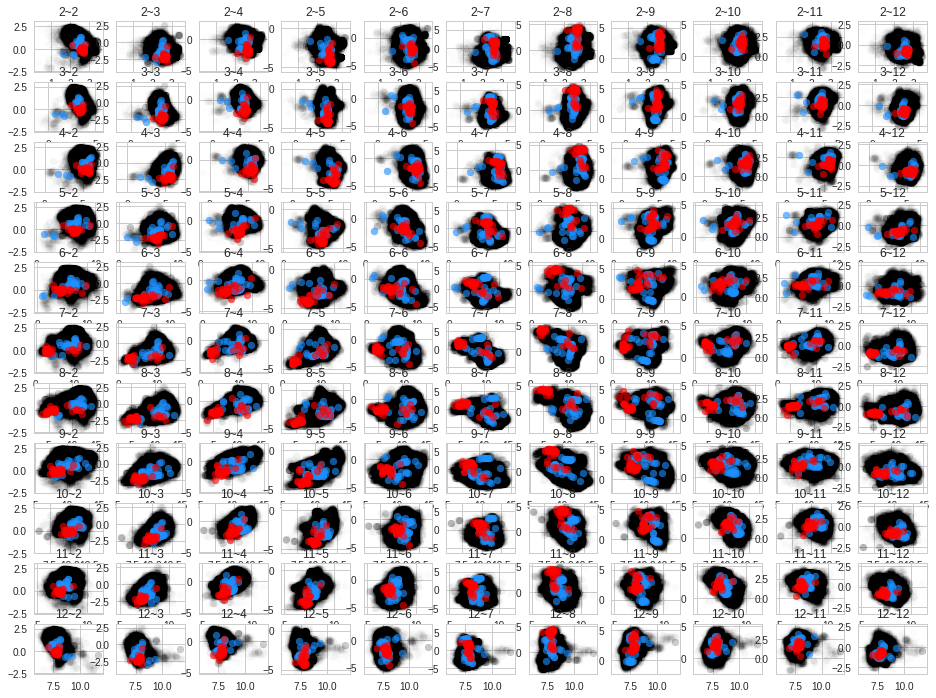

In [210]:
def plot_corr(df_put_l, df_put_r, df_cdr_l, df_cdr_r, pos_i, pos_j, ax):
    ax.scatter(df_put_l.loc[df_put_l["pos"] == pos_i, "value"], 
               df_put_r.loc[df_put_r["pos"] == pos_j, "value"], 
               color="black", alpha=.01)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos"] == pos_i) & (df_cdr_l["chain"] == "TRA"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos"] == pos_j) & (df_cdr_r["chain"] == "TRA"), "value"], 
               color="dodgerblue", alpha=.6)
    ax.scatter(df_cdr_l.loc[(df_cdr_l["pos"] == pos_i) & (df_cdr_l["chain"] == "TRB"), "value"], 
               df_cdr_r.loc[(df_cdr_r["pos"] == pos_j) & (df_cdr_r["chain"] == "TRB"), "value"], 
               color="red", alpha=.6)
    ax.set_title(str(pos_i+1) + "~" + str(pos_j+1))


fig, ax = plt.subplots(MAX_POS-1, MAX_POS-1, figsize=(16,12))

# plt.tight_layout(h_pad=3)

for r in range(MAX_POS-1):
    for c in range(MAX_POS-1):
        plot_corr(df_put_x, df_put_y, df_cdr_x, df_cdr_y, r+1, c+1, ax[r,c])

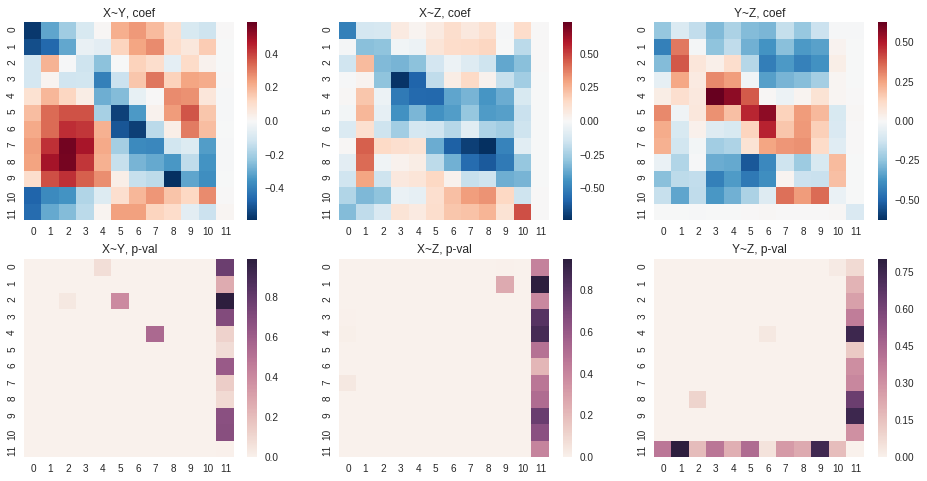

In [211]:
def plot_heatmap(df_x, df_y, df_z, fun):
    def compute(df1, df2):
        cors = np.zeros((MAX_POS,MAX_POS))
        pvals = np.zeros((MAX_POS,MAX_POS))
        for i in range(1,MAX_POS+1):
            for j in range(1,MAX_POS+1):
                val = stats.pearsonr(df1.loc[df1["pos"] == i, "value"], df2.loc[df2["pos"] == j, "value"])
                cors[i-1,j-1] = val[0]
                pvals[i-1,j-1] = val[1]
        return cors, pvals
    
    fig, ax = plt.subplots(2,3, figsize=(16,8))
    
    cors1, pvals1 = compute(df_x, df_y)
    ax[0,0].set_title("X~Y, coef")
    sns.heatmap(cors1, ax=ax[0,0])
    ax[1,0].set_title("X~Y, p-val")
    sns.heatmap(pvals1, ax=ax[1,0])
    
    cors2, pvals2 = compute(df_x, df_z)
    ax[0,1].set_title("X~Z, coef")
    sns.heatmap(cors2, ax=ax[0,1])
    ax[1,1].set_title("X~Z, p-val")
    sns.heatmap(pvals2, ax=ax[1,1])
    
    cors3, pvals3 = compute(df_y, df_z)
    ax[0,2].set_title("Y~Z, coef")
    sns.heatmap(cors3, ax=ax[0,2])
    ax[1,2].set_title("Y~Z, p-val")
    sns.heatmap(pvals3, ax=ax[1,2])
    
    return ((cors1, pvals1), (cors2, pvals2), (cors3, pvals3))

    
(p_c1, p_p1), (p_c2, p_p2), (p_c3, p_p3) = plot_heatmap(df_put_x, df_put_y, df_put_z, stats.pearsonr)

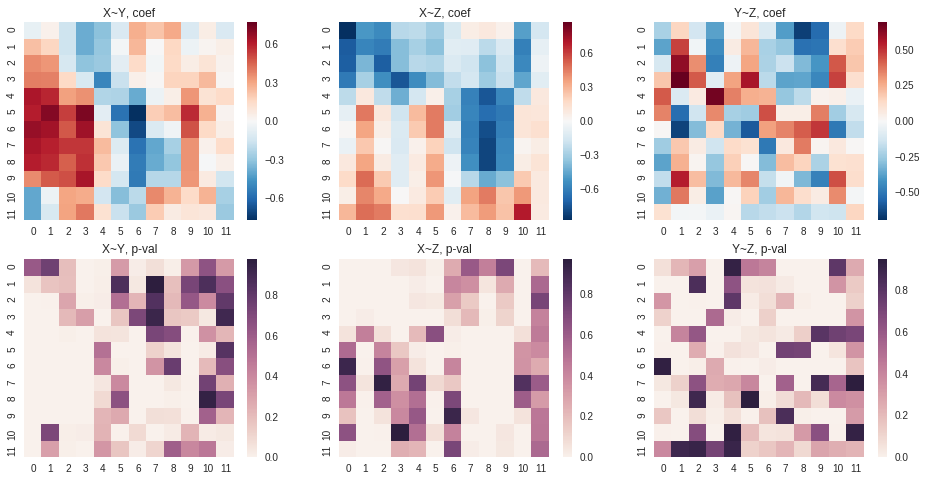

In [212]:
(c_c1, c_p1), (c_c2, c_p2), (c_c3, c_p3) = plot_heatmap(df_cdr_x, df_cdr_y, df_cdr_z, stats.pearsonr)

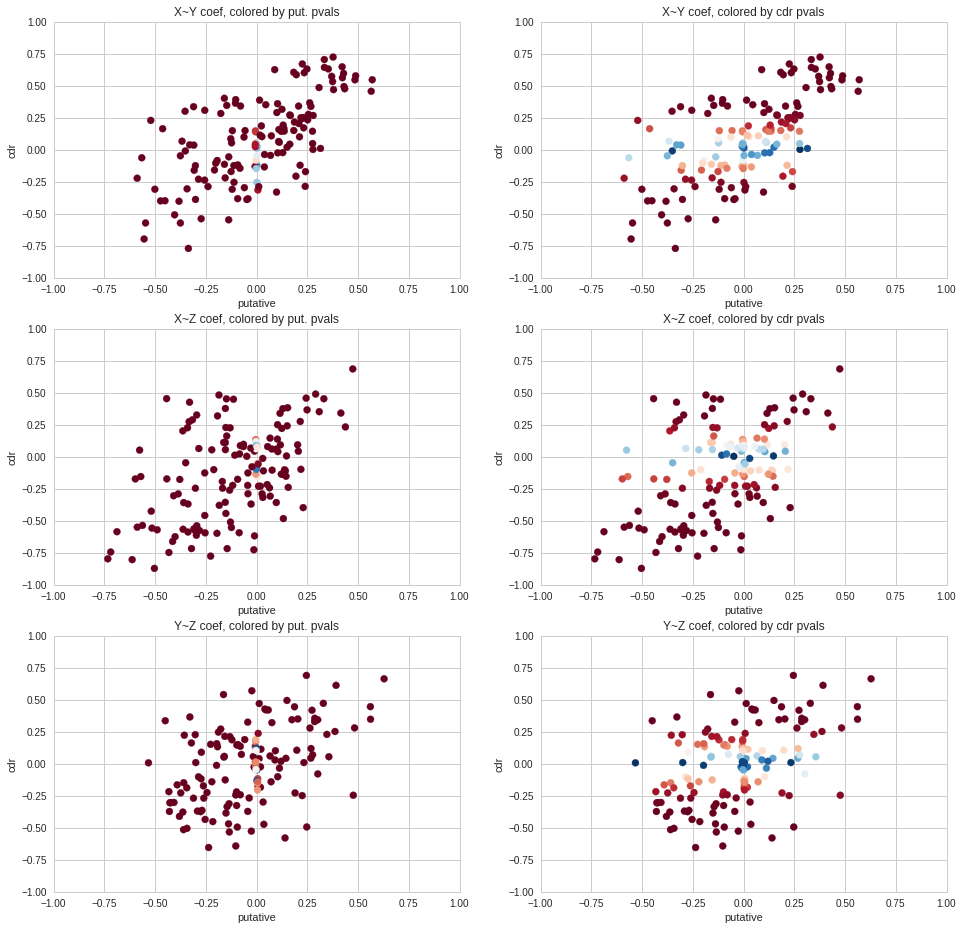

In [213]:
fig, ax = plt.subplots(3, 2, figsize=(16,16))


ax[0,0].set_xlabel('putative')
ax[0,0].set_ylabel('cdr')
ax[0,0].set_xlim([-1,1])
ax[0,0].set_ylim([-1,1])
ax[0,0].scatter(p_c1, c_c1, c = p_p1, cmap="RdBu")
ax[0,0].set_title("X~Y coef, colored by put. pvals")

ax[0,1].set_xlabel('putative')
ax[0,1].set_ylabel('cdr')
ax[0,1].set_xlim([-1,1])
ax[0,1].set_ylim([-1,1])
ax[0,1].scatter(p_c1, c_c1, c = c_p1, cmap="RdBu")
ax[0,1].set_title("X~Y coef, colored by cdr pvals")

ax[1,0].set_xlabel('putative')
ax[1,0].set_ylabel('cdr')
ax[1,0].set_xlim([-1,1])
ax[1,0].set_ylim([-1,1])
ax[1,0].scatter(p_c2, c_c2, c = p_p2, cmap="RdBu")
ax[1,0].set_title("X~Z coef, colored by put. pvals")

ax[1,1].set_xlabel('putative')
ax[1,1].set_ylabel('cdr')
ax[1,1].set_xlim([-1,1])
ax[1,1].set_ylim([-1,1])
ax[1,1].scatter(p_c2, c_c2, c = c_p2, cmap="RdBu")
ax[1,1].set_title("X~Z coef, colored by cdr pvals")

ax[2,0].set_xlabel('putative')
ax[2,0].set_ylabel('cdr')
ax[2,0].set_xlim([-1,1])
ax[2,0].set_ylim([-1,1])
ax[2,0].scatter(p_c3, c_c3, c = p_p3, cmap="RdBu")
ax[2,0].set_title("Y~Z coef, colored by put. pvals")

ax[2,1].set_xlabel('putative')
ax[2,1].set_ylabel('cdr')
ax[2,1].set_xlim([-1,1])
ax[2,1].set_ylim([-1,1])
ax[2,1].scatter(p_c3, c_c3, c = c_p3, cmap="RdBu")
ax[2,1].set_title("Y~Z coef, colored by cdr pvals")

## Summary

Many non-zero and strong correlations gives us a hope for building a model for prediction of coordinates based on two other coordinates.

Correlations are very similar for both datasets, however, more careful analysis of outliers is needed in order to make robust training test.

Strong correlations may exist due to the huge imbalance in the data, i.e., imbalance in the "upside" / "downside" peptide counts.

# Distribution of distances to the nearest putative CDR from real CDRs (by MSE)

<a id="distrdist"></a>

In [17]:
arr_put_coord = np.hstack([np.array(df_put_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_put_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_put_coord_z[range(0,MAX_POS+1)])])

arr_can_coord = np.hstack([np.array(df_can_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_can_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_can_coord_z[range(0,MAX_POS+1)])])

arr_cdr_coord = np.hstack([np.array(df_cdr_coord_x[range(0,MAX_POS+1)]),
                           np.array(df_cdr_coord_y[range(0,MAX_POS+1)]),
                           np.array(df_cdr_coord_z[range(0,MAX_POS+1)])])

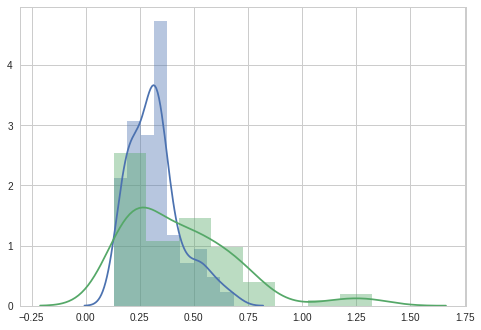

In [18]:
dist = []
for arr in arr_cdr_coord:
    dist.append(np.sqrt(((arr_put_coord - arr) ** 2).mean(1).min()))
    
sns.distplot(dist)


dist = []
for arr in arr_cdr_coord:
    dist.append(np.sqrt(((arr_can_coord - arr) ** 2).mean(1).min()))
    
sns.distplot(dist)

# Clustering

<a id="clust"></a>

Counter({1: 30, 0: 24, 2: 12, 3: 3})


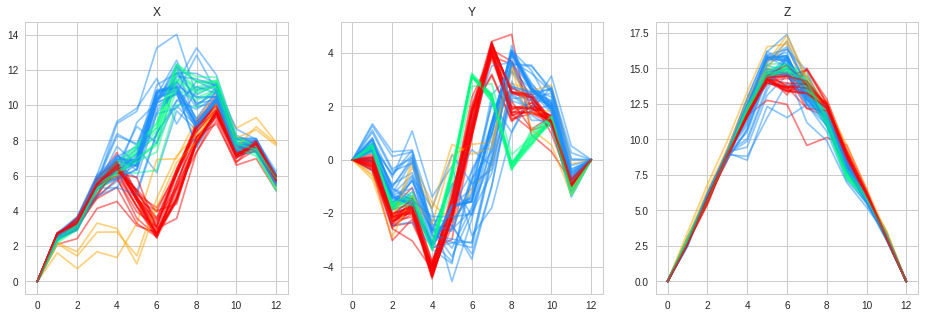

In [20]:
from collections import Counter

colors = ["red", "dodgerblue", "springgreen", "orange", "magenta", "black", "maroon", "aqua", "gold"]

def clust_and_plot(X, n_clusters):
    clust = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000, n_init=10)
    clust.fit(X)
    pred = clust.predict(X)
    
    print(Counter(pred))

    fig, ax = plt.subplots(1,3,figsize=(16,5))
    ax[0].set_title("X")
    ax[1].set_title("Y")
    ax[2].set_title("Z")

    permut = np.random.permutation(range(X.shape[0]))
    pred = pred[permut]
    
    for i, row in enumerate(X[permut]):
        ax[0].plot(range(MAX_POS+1), row[range(0, MAX_POS+1)], c=colors[pred[i]], alpha=.5)
        ax[1].plot(range(MAX_POS+1), row[range(MAX_POS+1, 2*MAX_POS+2)], c=colors[pred[i]], alpha=.5)
        ax[2].plot(range(MAX_POS+1), row[range(2*MAX_POS+2, 3*MAX_POS+3)], c=colors[pred[i]], alpha=.5)
        if i > 1000:
            break
            
    return clust.cluster_centers_,  \
           np.array([np.std(c - X, 0) for c in clust.cluster_centers_]), \
           pred


pred = {"cdr":{}, "can":{}, "put":{}}
centroids = {"cdr":{}, "can":{}, "put":{}}
std = {"cdr":{}, "can":{}, "put":{}}
centroids["cdr"][4], std["cdr"][4], pred["cdr"][4] = clust_and_plot(arr_cdr_coord, 4)

Counter({1: 24, 2: 20, 0: 12, 3: 10, 4: 3})


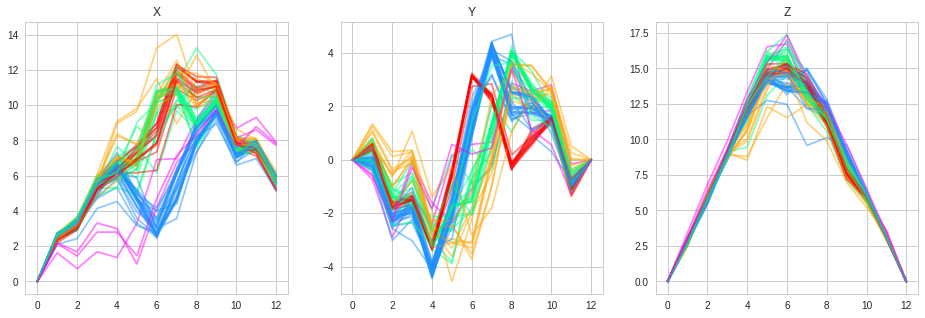

In [21]:
centroids["cdr"][5], std["cdr"][5], pred["cdr"][5] = clust_and_plot(arr_cdr_coord, 5)

Counter({2: 24, 1: 20, 3: 12, 5: 8, 0: 3, 4: 2})


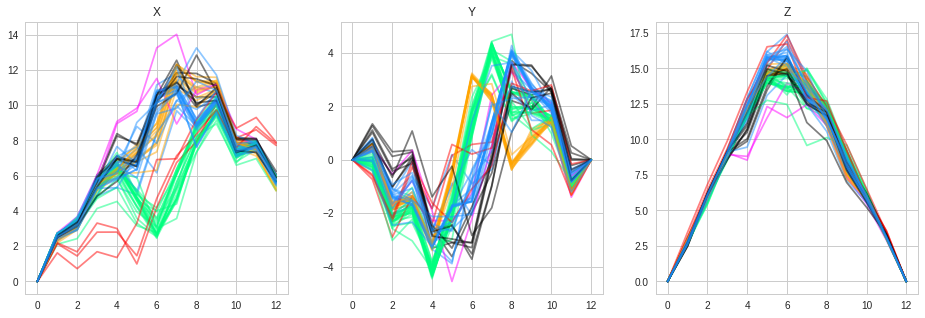

In [22]:
centroids["cdr"][6], std["cdr"][6], pred["cdr"][6] = clust_and_plot(arr_cdr_coord, 6)

Counter({1: 92, 0: 89, 2: 59, 3: 41})


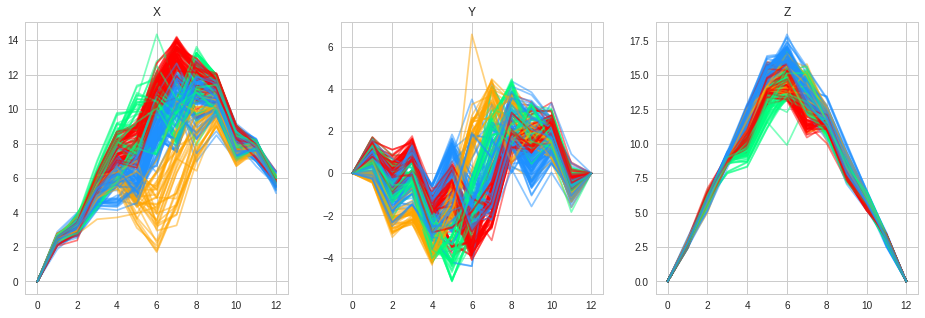

In [23]:
centroids["can"][4], std["can"][4], pred["can"][4] = clust_and_plot(arr_can_coord, 4)

Counter({1: 71, 2: 66, 3: 63, 0: 48, 4: 33})


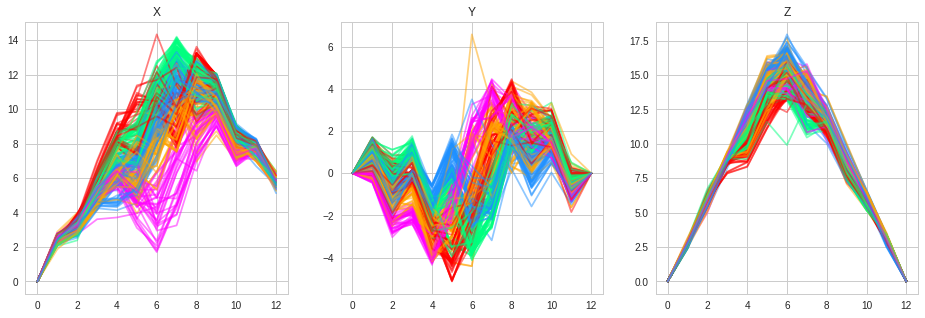

In [24]:
centroids["can"][5], std["can"][5], pred["can"][5] = clust_and_plot(arr_can_coord, 5)

Counter({1: 68, 4: 46, 3: 45, 5: 45, 2: 41, 0: 36})


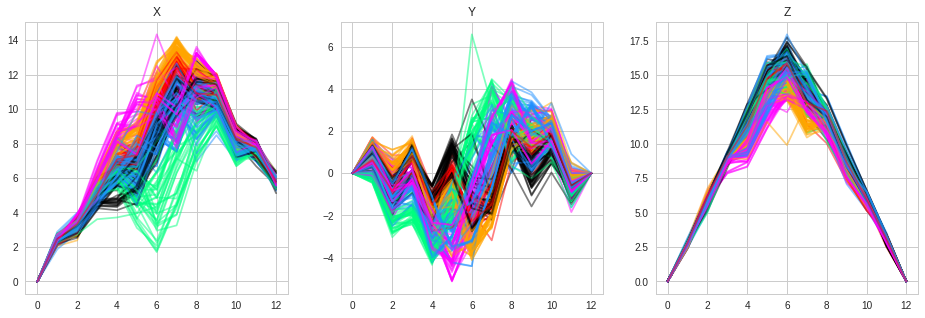

In [25]:
centroids["can"][6], std["can"][6], pred["can"][6] = clust_and_plot(arr_can_coord, 6)

Counter({1: 26962, 2: 23257, 0: 14435, 3: 9874})


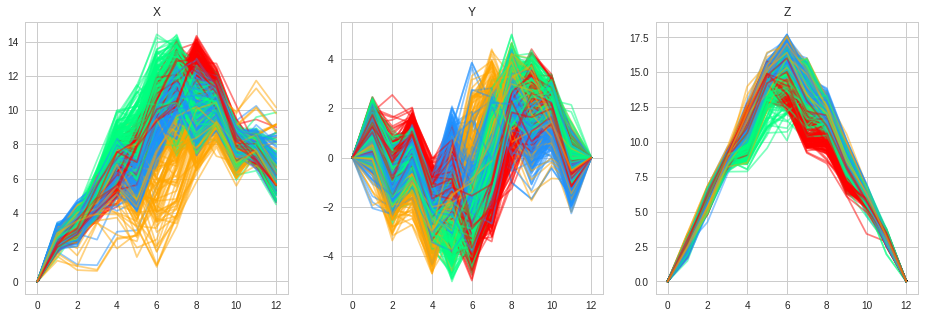

In [26]:
centroids["put"][4], std["put"][4], pred["put"][4] = clust_and_plot(arr_put_coord, 4)

Counter({2: 21758, 1: 21725, 0: 12662, 3: 10026, 4: 8357})


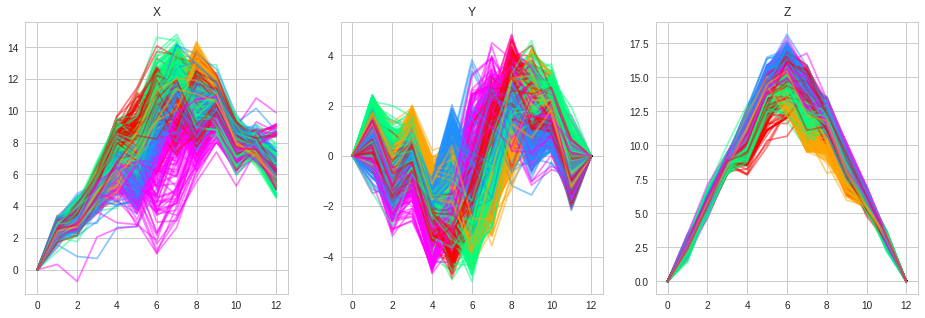

In [27]:
centroids["put"][5], std["put"][5], pred["put"][5] = clust_and_plot(arr_put_coord, 5)

Counter({2: 18123, 1: 17078, 3: 12236, 0: 11936, 4: 8884, 5: 6271})


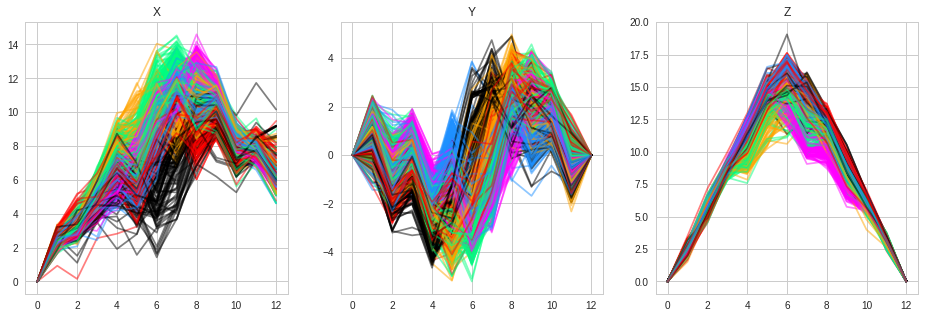

In [28]:
centroids["put"][6], std["put"][6], pred["put"][6] = clust_and_plot(arr_put_coord, 6)

## Centroids

<a id="centroids"></a>

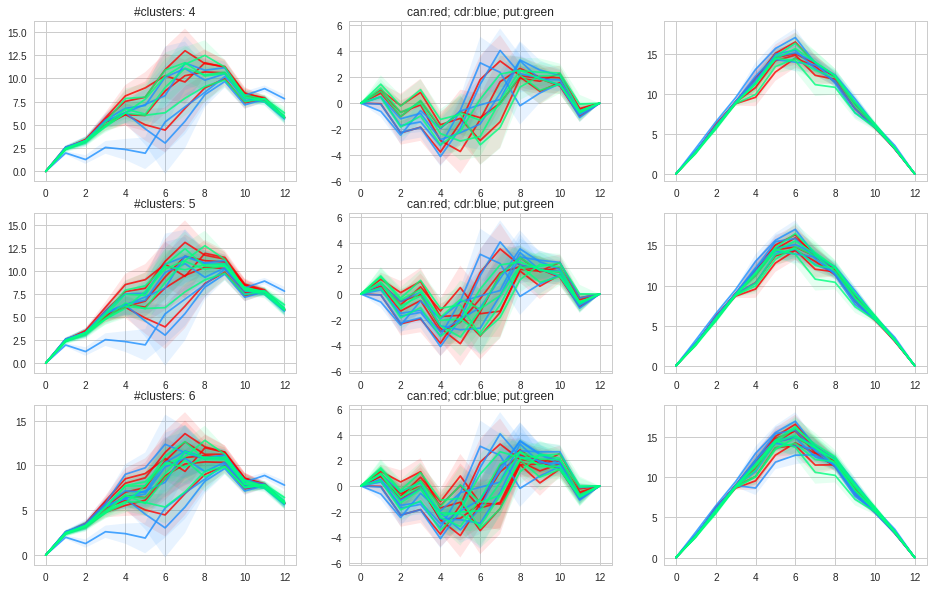

In [29]:
fig, ax = plt.subplots(3,3,figsize=(16,10))

for r,i in enumerate(range(4,7)):
    for data_i, data_type in enumerate(sorted(centroids.keys())):
        for clust_i in range(i):
            cur_data = centroids[data_type][i][clust_i][range(MAX_POS+1)]
            cur_std = std[data_type][i][clust_i][range(MAX_POS+1)]
            ax[r,0].plot(range(MAX_POS+1), cur_data, 
                         c=colors[data_i], alpha=.8)
            ax[r,0].fill_between(range(MAX_POS+1), 
                                 cur_data - cur_std,
                                 cur_data + cur_std,
                                 facecolor=colors[data_i], alpha=0.1)
            
            cur_data = centroids[data_type][i][clust_i][range(MAX_POS+1, 2*MAX_POS+2)]
            cur_std = std[data_type][i][clust_i][range(MAX_POS+1, 2*MAX_POS+2)]
            ax[r,1].plot(range(MAX_POS+1), cur_data, 
                         c=colors[data_i], alpha=.8)
            ax[r,1].fill_between(range(MAX_POS+1), 
                                 cur_data - cur_std,
                                 cur_data + cur_std,
                                 facecolor=colors[data_i], alpha=0.1)
            
            cur_data = centroids[data_type][i][clust_i][range(2*MAX_POS+2, 3*MAX_POS+3)]
            cur_std = std[data_type][i][clust_i][range(2*MAX_POS+2, 3*MAX_POS+3)]
            ax[r,2].plot(range(MAX_POS+1), cur_data, 
                         c=colors[data_i], alpha=.8)
            ax[r,2].fill_between(range(MAX_POS+1), 
                                 cur_data - cur_std,
                                 cur_data + cur_std,
                                 facecolor=colors[data_i], alpha=0.1)
            ax[r,0].set_title("#clusters: " + str(i))
            ax[r,1].set_title("can:red; cdr:blue; put:green")

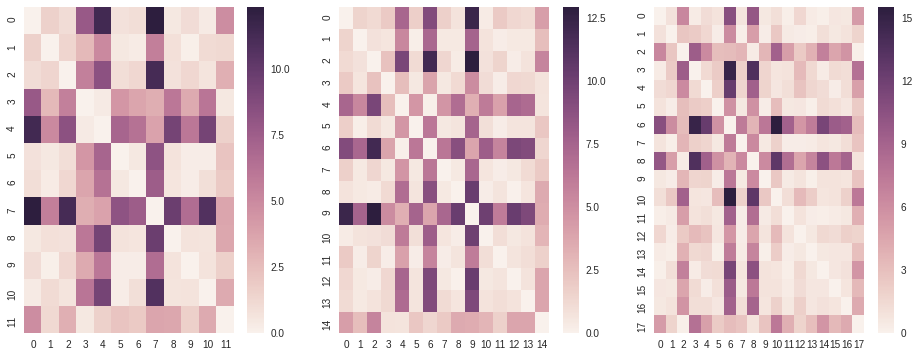

In [30]:
fig, ax = plt.subplots(1,3,figsize=(16,6))

# divergence from each centroid

for r,i in enumerate(range(4,7)):
    dist = np.zeros((i*3, i*3))
    for data_i, data_type_i in enumerate(sorted(centroids.keys())):
        for clust_i in range(i):
            for data_j, data_type_j in enumerate(sorted(centroids.keys())):
                for clust_j in range(i):
                    dist[data_i*i + clust_i, data_j*i + clust_j] = np.mean(
                        (centroids[data_type_i][i][clust_i][range(MAX_POS+1)] - 
                         centroids[data_type_j][i][clust_j][range(MAX_POS+1)]) ** 2)
    sns.heatmap(dist, ax=ax[r])

## Motifs from centroids

<a id="motifs"></a>

### Position-weight matricx

In [34]:
from Bio import motifs
from Bio.Seq import Seq

In [35]:
pred["cdr"][4]
pred["can"][5]
pred["put"][6]

array([2, 5, 1, ..., 5, 1, 5], dtype=int32)

### Sequence logo plots per cluster

### Naive classifier